# Import libraries

In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.genmod.cov_struct as smcs
import statsmodels.formula.api as smf
from IPython.display import HTML, display

# Stats
from scipy import stats

# Some constants
data_file = 'https://raw.githubusercontent.com/hieubkvn123/MH6321-project/main/data/full-data.csv'

# Load data

In [2]:
df_full = pd.read_csv(data_file)

In [3]:
### Some constants ###
alpha = 0.001

### Utility functions ###
def _pvalue_table_cell_styler(val):
    default_style = 'border : 1px solid black;'
    if(val < alpha):
        return default_style + 'background-color: red; color: black'
    elif(val == 1.0):
        return default_style + 'background-color: grey'
    elif(str(val) == 'nan'):
        return default_style + 'background-color: black'
    else:
        return default_style + 'background-color: green'

### Columns and mappings ###
heart_diseases = [
    'PREVCHD', 'PREVAP', 'PREVMI', 'PREVSTRK', 'PREVHYP'
]

disease_dict = {
    'PREVCHD' : 'Coronary Heart Disease',
    'PREVAP' : 'Angina Pectoris',
    'PREVMI' : 'Myocardial Infarction',
    'PREVSTRK' : 'Stroke',
    'PREVHYP' : 'Hypertensive'
}

cardiovascular_risks = [
    'TOTCHOL', 'SYSBP', 'DIABP', # Cholesterol + Blood pressure
    'CIGPDAY', # Smoking habits
    'BMI', 'GLUCOSE', # Fat people
]

risk_dict = {
    'TOTCHOL' : 'Serum cholesterol',
    'SYSBP' : 'Systolic blood pressure',
    'DIABP' : 'Diastolic blood pressure',
    'CIGPDAY' : 'Cigarettes per day',
    'BMI' : 'Body mass index',
    'GLUCOSE' : 'Casual glucose'
}

# I. Age versus cardiovascular risks

## 1. Divide the data into age groups

In [4]:
age_bins = [35, 45, 55, 65, 75, 85]
age_labels = ['35-44', '44-54', '55-64', '65-74', '75-84']
df_full['AGEGROUP'] = pd.cut(df_full['AGE'], bins=age_bins, labels=age_labels, right=False)

In [5]:
df_full.head(5)

,RANDID,SEX,TOTCHOL,AGE,SYSBP,DIABP,CURSMOKE,CIGPDAY,BMI,DIABETES,...,HYPERTEN,TIMEAP,TIMEMI,TIMEMIFC,TIMECHD,TIMESTRK,TIMECVD,TIMEDTH,TIMEHYP,AGEGROUP
0,2448,1,195.0,39,106.0,70.0,0,0.0,26.97,0,...,0,8766,6438,6438,6438,8766,6438,8766,8766,35-44
1,2448,1,209.0,52,121.0,66.0,0,0.0,NaN,0,...,0,8766,6438,6438,6438,8766,6438,8766,8766,44-54
2,6238,2,250.0,46,121.0,81.0,0,0.0,28.73,0,...,0,8766,8766,8766,8766,8766,8766,8766,8766,44-54
3,6238,2,260.0,52,105.0,69.5,0,0.0,29.43,0,...,0,8766,8766,8766,8766,8766,8766,8766,8766,44-54
4,6238,2,237.0,58,108.0,66.0,0,0.0,28.50,0,...,0,8766,8766,8766,8766,8766,8766,8766,8766,55-64


## 2. Visualize cardiovascular risks of different age groups
- Among people with cardiovascular diseases, is there a significant difference in cardiovascular risks across different age groups? For example, among people with hypertension, is there a significant difference in the bmi of people from 35-44 and people from 55-64 years of age?

- For each age group, is there a significant difference in the intensity of cardiovascular risks between non-prevalent and prevalent heart disease? For example, among people from 35-44 years of age, is there a difference in the level of cholesterol between people with Angina Pectoris and people who do not have AP?

### 2.1. Initial visualizations

[INFO] VISUALIZATION FOR : CORONARY HEART DISEASE


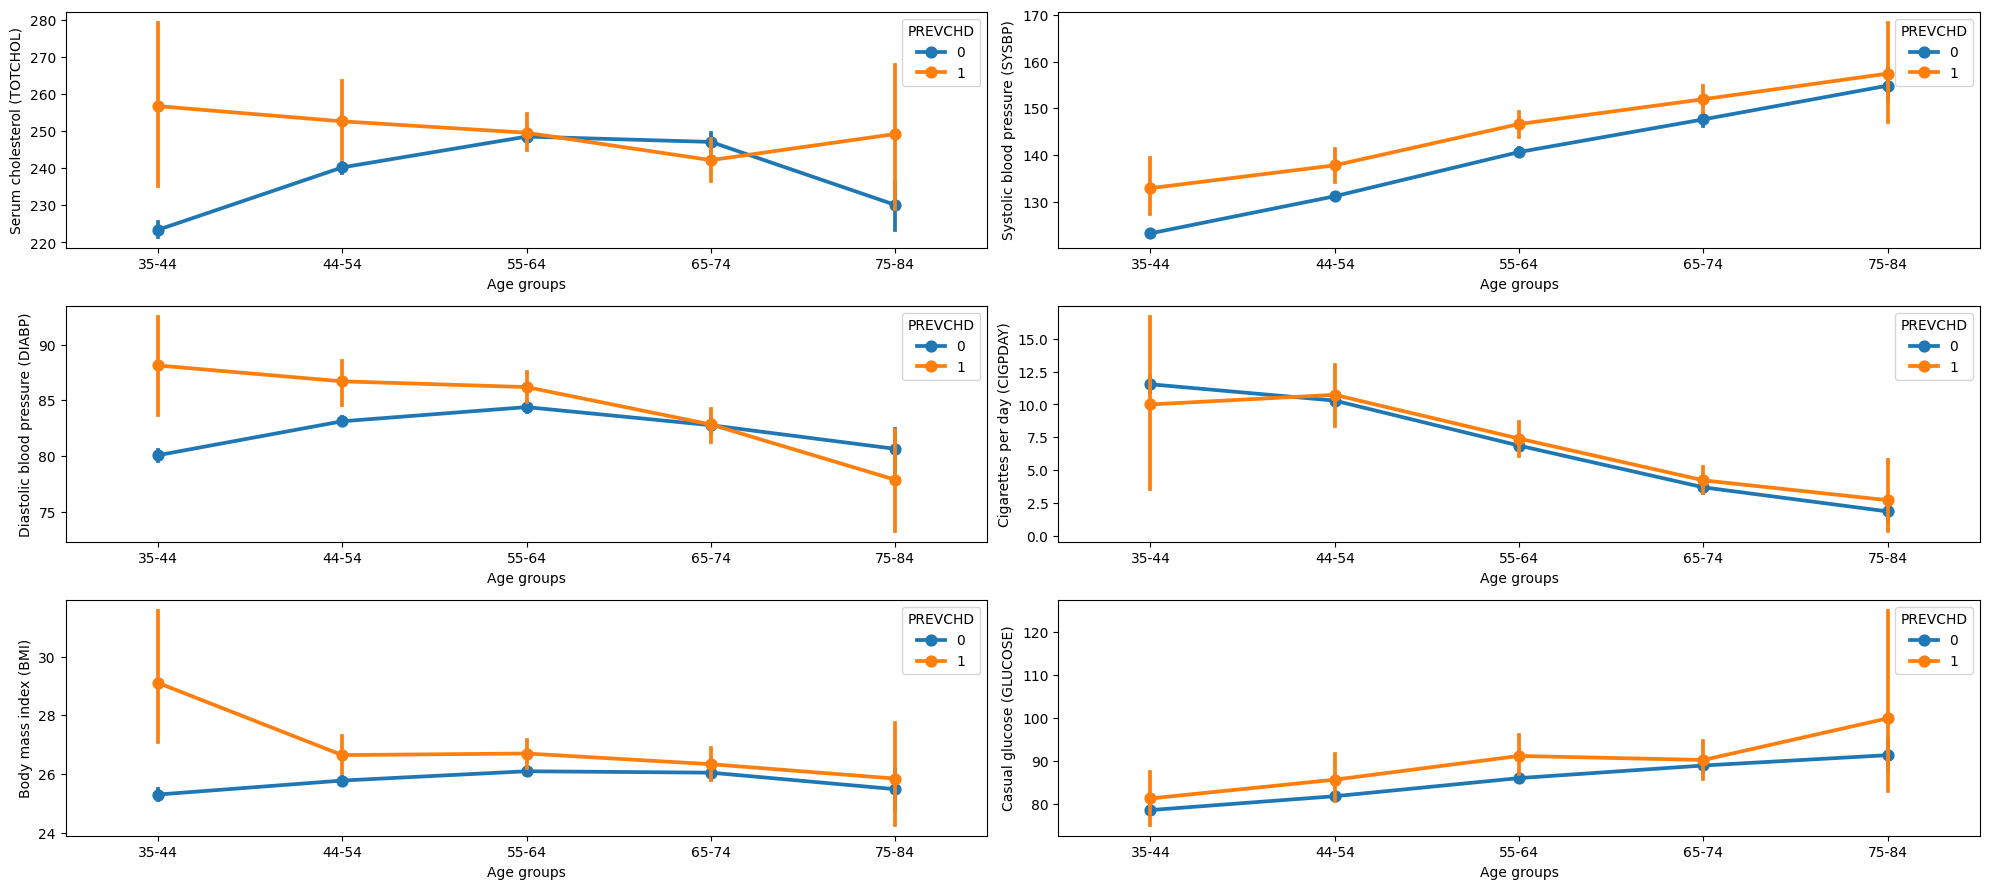


[INFO] VISUALIZATION FOR : ANGINA PECTORIS


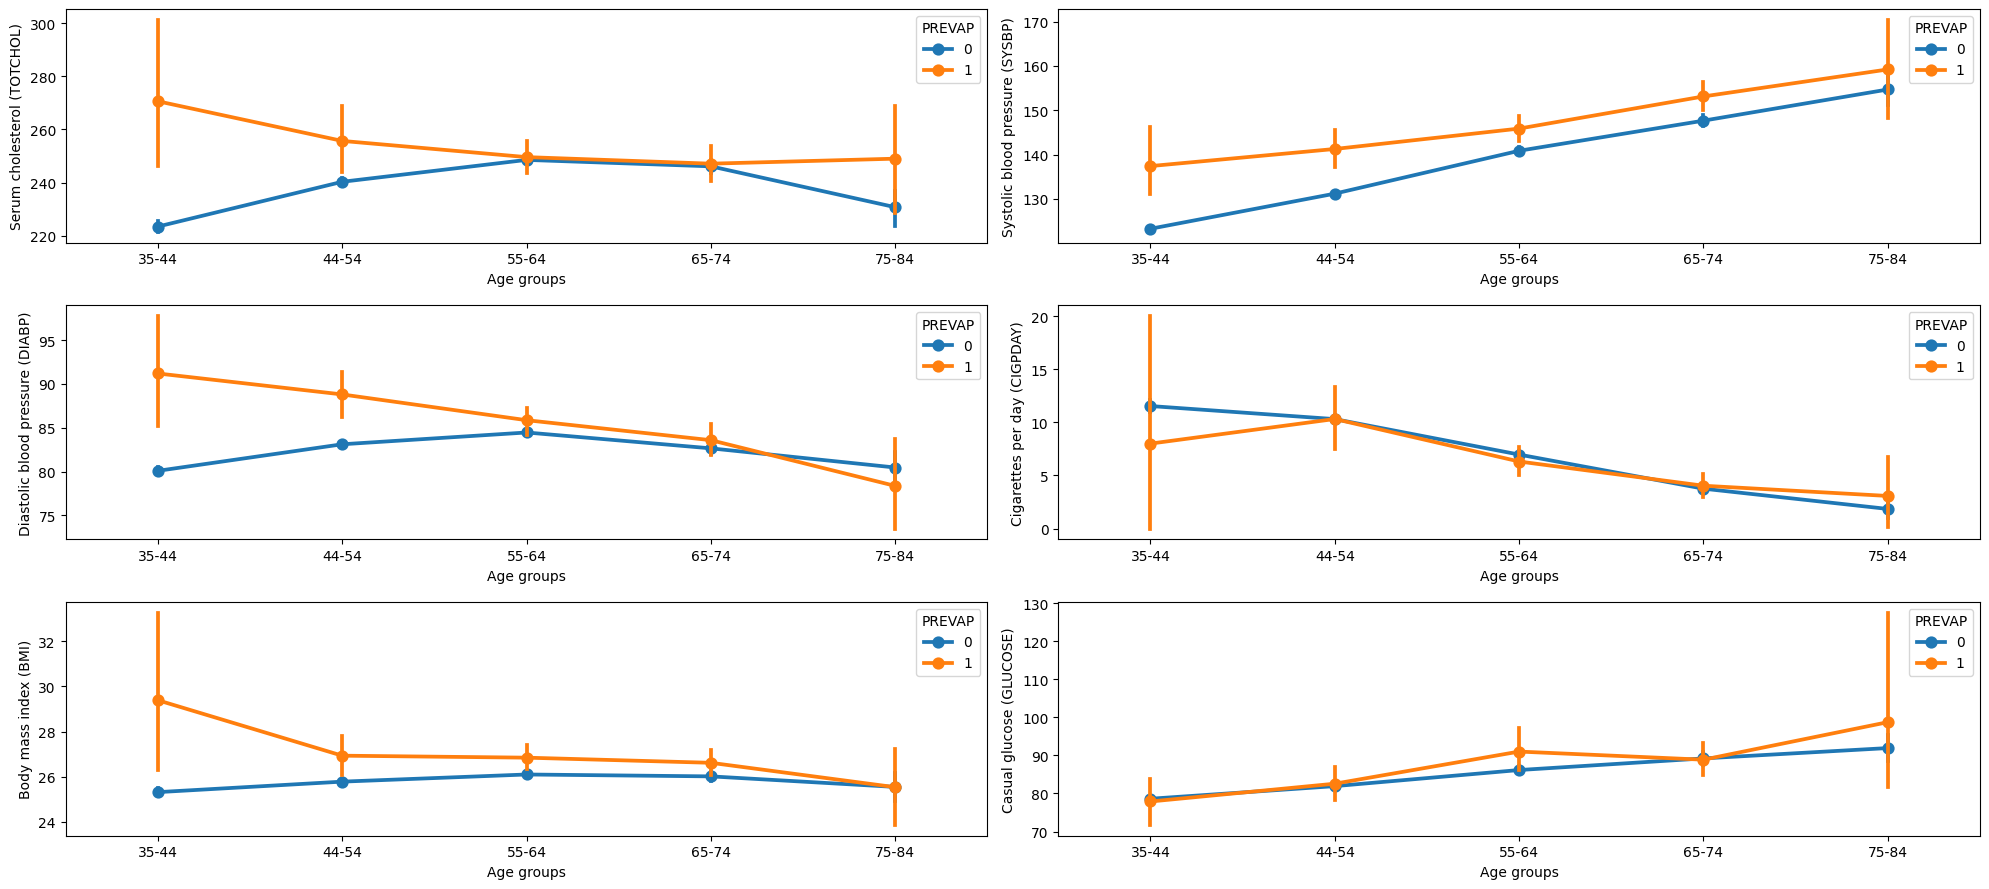


[INFO] VISUALIZATION FOR : MYOCARDIAL INFARCTION


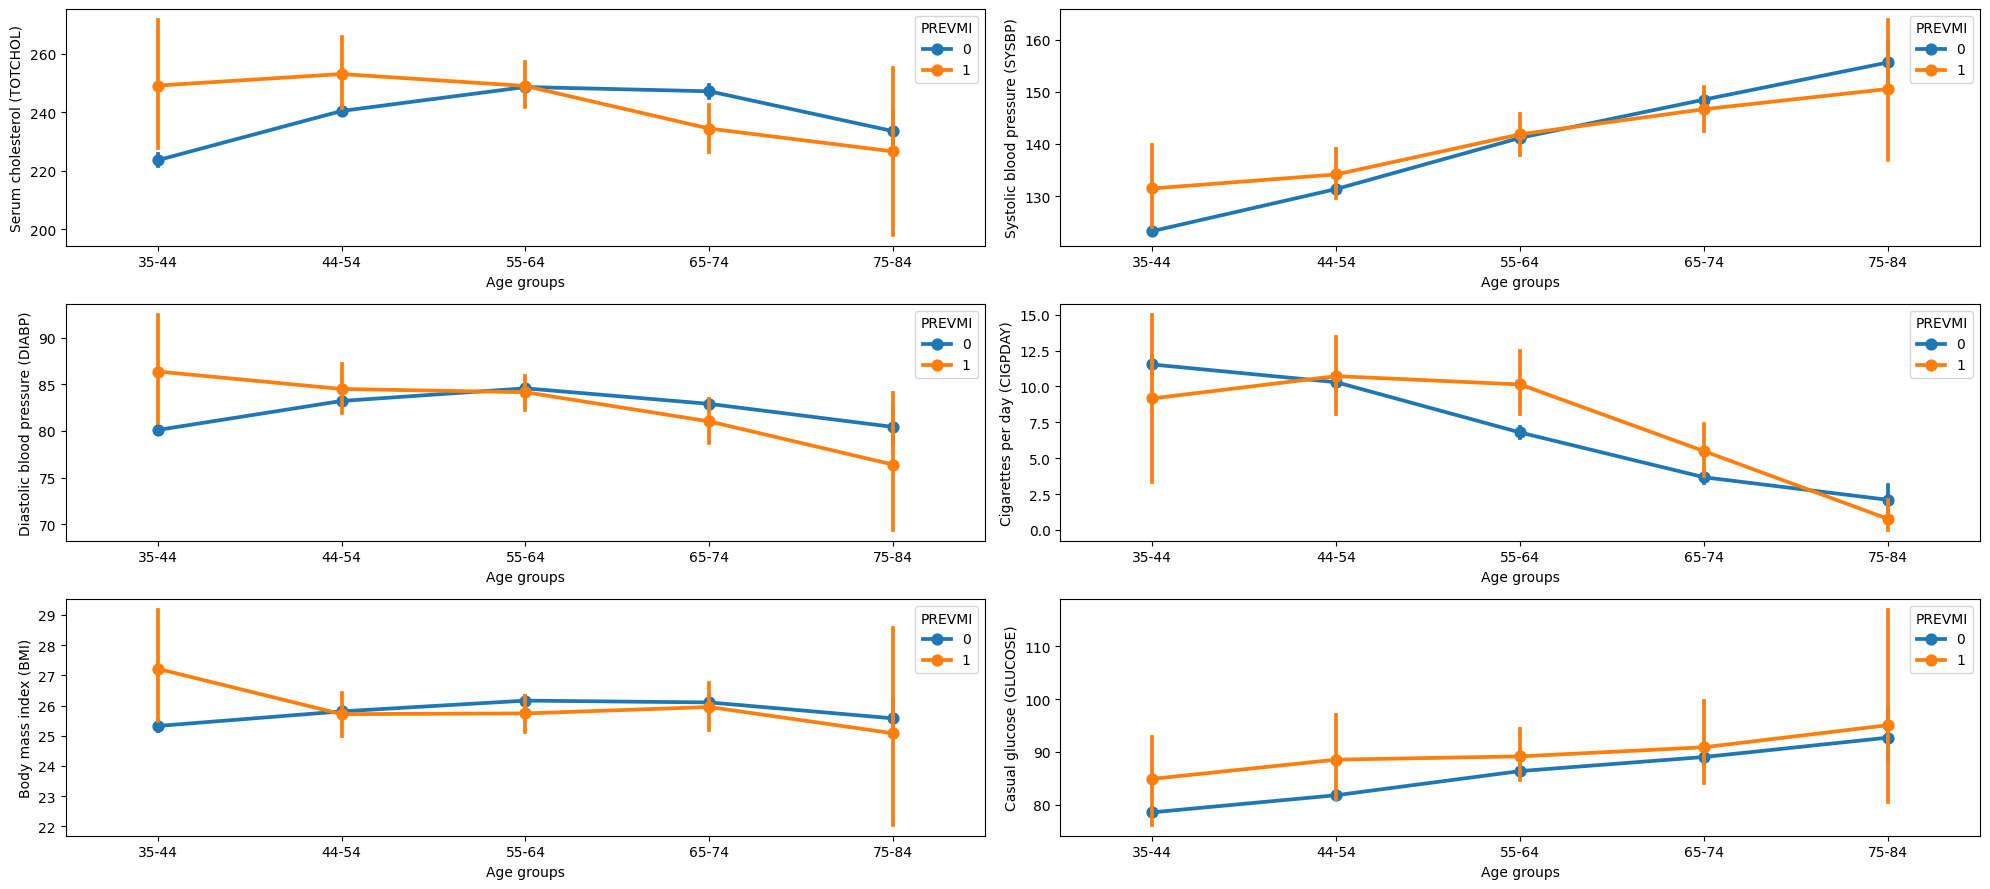


[INFO] VISUALIZATION FOR : STROKE


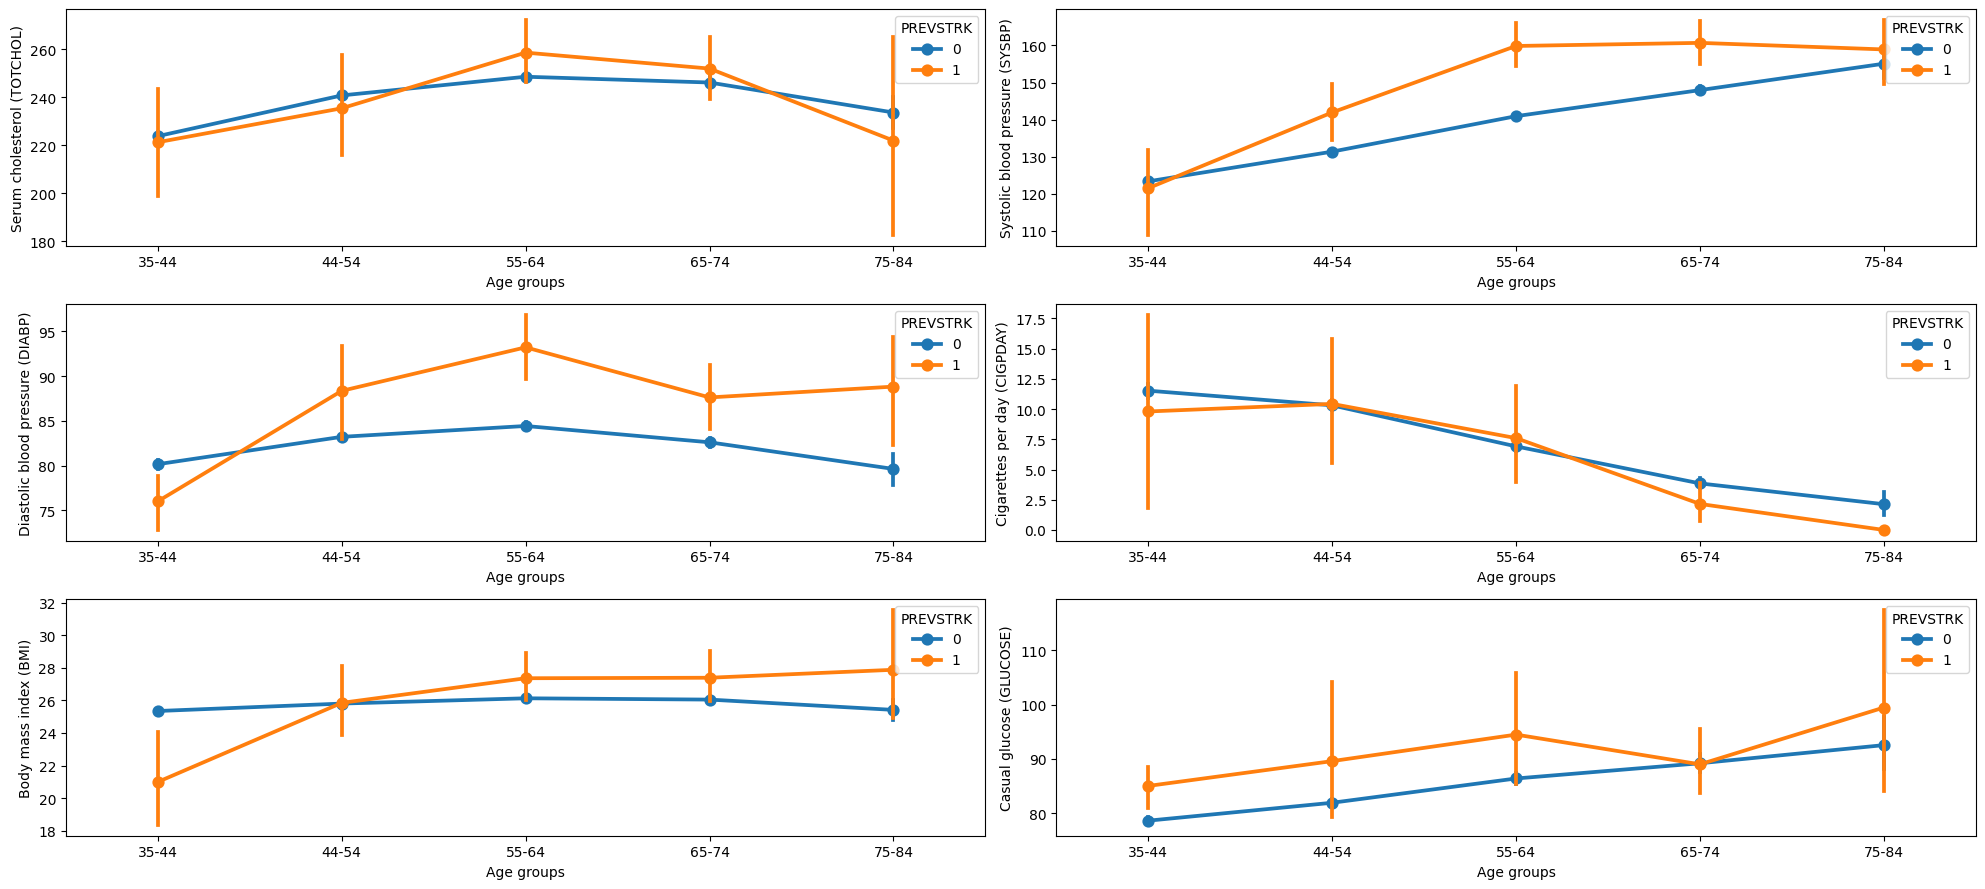


[INFO] VISUALIZATION FOR : HYPERTENSIVE


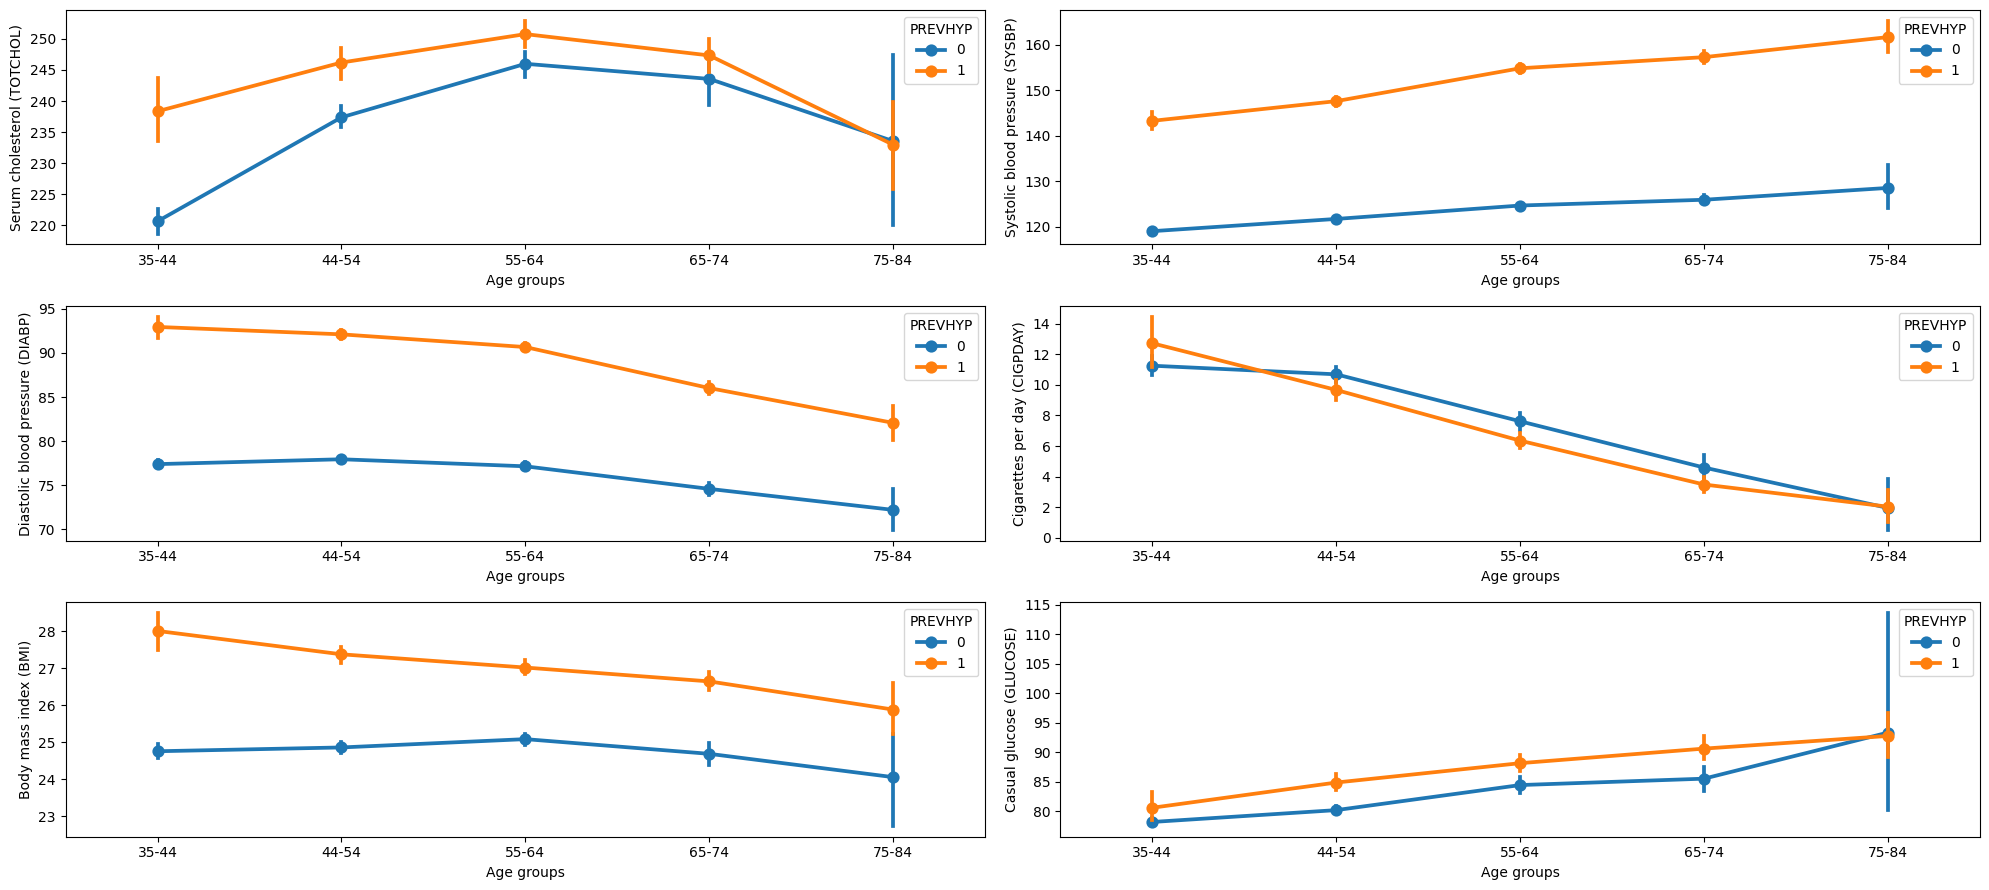

In [6]:
def visualize_cardiovascular_risks(disease):
  print(f'[INFO] VISUALIZATION FOR : {disease_dict[disease].upper()}')
  _, axes = plt.subplots(3,2, figsize=(20, 9))

  for i, risk in enumerate(cardiovascular_risks):
    row = i // 2
    col = i  % 2
    axes[row][col] = sns.pointplot(data=df_full, y=risk, x='AGEGROUP', hue=disease,ax=axes[row][col])
    axes[row][col].set_ylabel(f'{risk_dict[risk]} ({risk})')
    axes[row][col].set_xlabel('Age groups')
  plt.tight_layout()
  plt.show()

for disease in heart_diseases:
  visualize_cardiovascular_risks(disease)
  print('=' * 150 + '\n')

### 2.2. How cardiovascular risks vary with age
- For every cardiovascular disease, an one-way ANOVA test will be conducted for each risk factor to identify if certain risk factors that varies significantly with respect to age.
- Upon identifying these factors, it answers the question "When diagnosing a subject for a certain heart disease, which factors are age-dependent".

In [7]:
def oneway_f_test(disease, risk):
  # Get subjects with corresponding disease
  df_disease = df_full[df_full[disease] == 1]

  # Remove subjects with empty risk factor
  df_disease = df_disease[~df_disease[risk].isna()]

  # Oneway F-test for the groups
  groups = [df_disease[df_disease['AGEGROUP'] == group][risk].values for group in age_labels]
  results = stats.f_oneway(*groups)

  return results.statistic, results.pvalue

results = {}
statistics = {}
for disease in heart_diseases:
  results[disease], statistics[disease] = [], []
  for risk in cardiovascular_risks:
    F, pvalue = oneway_f_test(disease, risk)
    
    results[disease].append(pvalue)
    statistics[disease].append(F)

statistics = pd.DataFrame(statistics)
results = pd.DataFrame(results, index=cardiovascular_risks)
results = results.style.applymap(_pvalue_table_cell_styler)

print('[INFO] F-statistics : ')
display(HTML(statistics.to_html()))

print('[INFO] P-values :')
display(HTML(results.to_html()))


[INFO] F-statistics : 


,PREVCHD,PREVAP,PREVMI,PREVSTRK,PREVHYP
0,1.408967,0.842151,2.611068,1.944451,8.909281
1,10.904214,6.617077,4.672784,6.853732,69.859331
2,6.191576,5.376382,2.457509,2.511676,81.505202
3,10.022028,6.519142,4.530016,3.806636,79.799014
4,2.042261,1.522201,0.588096,1.854482,11.194282
5,1.133369,1.466989,0.189924,0.469623,10.950122


[INFO] P-values :


,PREVCHD,PREVAP,PREVMI,PREVSTRK,PREVHYP
TOTCHOL,0.229120,0.498745,0.035313,0.106495,0.000000
SYSBP,0.000000,0.000032,0.001087,0.000044,0.000000
DIABP,0.000065,0.000292,0.045275,0.044232,0.000000
CIGPDAY,0.000000,0.000038,0.001390,0.005683,0.000000
BMI,0.086617,0.194062,0.671454,0.121844,0.000000
GLUCOSE,0.339536,0.210890,0.943578,0.757943,0.000000


### 2.3. Overall prominent risk factors - Logistic regression
- This analysis answers the question "what are the prominent factors that put a subject under risk of having any cardiovascular disease".

In [8]:
# Get the target variable
df_full['PREV'] = (df_full[heart_diseases].sum(axis=1) > 0).to_numpy().astype(int)

# Logistic regression by age groups
coeffs, pvalues, z_scores = {}, {}, {}
for age_group in age_labels:
    # Separate age groups
    df_age = df_full[df_full['AGEGROUP'] == age_group]
    df_age = df_age[['PREV'] + cardiovascular_risks].dropna()
    
    # Fit the model
    log_reg = smf.logit(f"PREV ~ {'+'.join(cardiovascular_risks)}", data=df_age).fit(disp=0)

    # Get the z-scores
    cov = log_reg.cov_params()
    std_err = np.sqrt(np.diag(cov))
    z_values = log_reg.params / std_err

    # Store the coefficients + pvalues
    coeffs[age_group] = log_reg.params
    pvalues[age_group] = log_reg.pvalues
    z_scores[age_group] = z_values

# Format table
coeffs = pd.DataFrame(coeffs)
pvalues = pd.DataFrame(pvalues)
z_scores = pd.DataFrame(z_scores)
z_scores = z_scores.drop('Intercept')
pvalues = pvalues.drop('Intercept')
pvalues = pvalues.style.applymap(_pvalue_table_cell_styler)

print('[INFO] Logistic regression coefficients : ')
display(HTML(coeffs.to_html()))

print('\n[INFO] Z-scores :')
display(HTML(z_scores.to_html()))

print('\n[INFO] P-values :')
display(HTML(pvalues.to_html()))

[INFO] Logistic regression coefficients : 


,35-44,44-54,55-64,65-74,75-84
Intercept,-25.098545,-20.585372,-16.905965,-15.560513,-15.964173
TOTCHOL,0.002673,0.000121,-0.000525,-0.002566,0.007257
SYSBP,0.089583,0.082593,0.088950,0.097588,0.093657
DIABP,0.113504,0.080609,0.042892,0.015512,-0.002636
CIGPDAY,0.005409,-0.002605,-0.000749,0.003470,-0.002869
BMI,0.067029,0.078460,0.049572,0.069380,0.038258
GLUCOSE,-0.001168,0.004511,0.004149,0.009164,0.018772



[INFO] Z-scores :


,35-44,44-54,55-64,65-74,75-84
TOTCHOL,1.272574,0.111845,-0.455849,-1.556530,1.066024
SYSBP,9.719438,16.892413,19.726553,14.427648,4.303651
DIABP,7.775554,10.260497,6.025418,1.589532,-0.089688
CIGPDAY,0.805330,-0.743236,-0.171417,0.400025,-0.061994
BMI,2.922215,5.931191,3.497437,3.186823,0.547016
GLUCOSE,-0.190361,1.914570,2.075115,2.684617,1.051117



[INFO] P-values :


,35-44,44-54,55-64,65-74,75-84
TOTCHOL,0.203169,0.910946,0.648499,0.119582,0.286413
SYSBP,0.000000,0.000000,0.000000,0.000000,0.000017
DIABP,0.000000,0.000000,0.000000,0.111940,0.928535
CIGPDAY,0.420629,0.457339,0.863896,0.689138,0.950568
BMI,0.003476,0.000000,0.000470,0.001438,0.584368
GLUCOSE,0.849026,0.055547,0.037976,0.007261,0.293205


### 2.4. Prominent risk factors - GEE
- Since we have inter-correlation between different measurements of the same subject.

In [34]:
# Get the target variable
df_full['PREV'] = (df_full[heart_diseases].sum(axis=1) > 0).to_numpy().astype(int)

# Logistic regression by age groups
ar = smcs.Autoregressive(grid=True)
coeffs, pvalues, z_scores = {}, {}, {}
for age_group in age_labels:
    # Separate age groups
    df_age = df_full[df_full['AGEGROUP'] == age_group]
    df_age = df_age[['RANDID', 'PREV'] + cardiovascular_risks].dropna()
    
    # Fit the model
    gee_reg = smf.gee(f"PREV ~ {'+'.join(cardiovascular_risks)}", groups="RANDID", data=df_age).fit()

    # Get the z-scores
    cov = gee_reg.cov_params()
    std_err = np.sqrt(np.diag(cov))
    z_values = gee_reg.params / std_err

    # Store the coefficients + pvalues
    coeffs[age_group] = gee_reg.params
    pvalues[age_group] = gee_reg.pvalues
    z_scores[age_group] = z_values

# Format table
coeffs = pd.DataFrame(coeffs)
pvalues = pd.DataFrame(pvalues)
z_scores = pd.DataFrame(z_scores)
z_scores = z_scores.drop('Intercept')
pvalues = pvalues.drop('Intercept')
pvalues = pvalues.style.applymap(_pvalue_table_cell_styler)

print('[INFO] Logistic regression coefficients : ')
display(HTML(coeffs.to_html()))

print('\n[INFO] Z-scores :')
display(HTML(z_scores.to_html()))

print('\n[INFO] P-values :')
display(HTML(pvalues.to_html()))

[INFO] Logistic regression coefficients : 


,35-44,44-54,55-64,65-74,75-84
Intercept,-1.860054,-2.137458,-1.537378,-0.916701,-0.780500
TOTCHOL,0.000136,0.000160,-0.000051,-0.000152,0.000596
SYSBP,0.009191,0.010363,0.010474,0.008414,0.007120
DIABP,0.008812,0.009823,0.005551,0.002326,0.000736
CIGPDAY,0.000693,-0.000070,-0.000287,-0.000400,0.001115
BMI,0.007010,0.010674,0.006316,0.008213,0.009008
GLUCOSE,-0.000173,0.000403,0.000187,0.000597,0.000877



[INFO] Z-scores :


,35-44,44-54,55-64,65-74,75-84
TOTCHOL,0.683188,1.078488,-0.298278,-0.730470,1.146781
SYSBP,9.028484,17.943779,21.345921,16.221394,4.397382
DIABP,5.712725,9.791062,6.293534,2.421891,0.343361
CIGPDAY,0.966086,-0.140822,-0.435970,-0.331494,0.323500
BMI,2.892057,5.871908,3.175512,3.589949,1.650392
GLUCOSE,-0.321049,1.303322,0.725189,2.018843,1.570639



[INFO] P-values :


,35-44,44-54,55-64,65-74,75-84
TOTCHOL,0.494488,0.280816,0.765491,0.465103,0.251472
SYSBP,0.000000,0.000000,0.000000,0.000000,0.000011
DIABP,0.000000,0.000000,0.000000,0.015440,0.731327
CIGPDAY,0.334001,0.888011,0.662859,0.740271,0.746317
BMI,0.003827,0.000000,0.001496,0.000331,0.098863
GLUCOSE,0.748173,0.192465,0.468336,0.043504,0.116266


### 2.5. Prominent risk factors - Independent t-test
- For each age groups, identify the most prominent risk factors by conducting an independent t-test on the groups of prevalent disease and non-prevalent diseases subjects.
- This analysis answers the question "for each age group, what risk factors is the most present in a prevalent heart disease patient as compared to a regular person".

In [10]:
for disease in heart_diseases:
  print('\n[INFO] Prominent risk factors for ', disease_dict[disease].upper())
  for age_group in age_labels:
    # Get the groups
    df_age = df_full[df_full['AGEGROUP'] == age_group]
    df_prev = df_age[df_age[disease] == 1]
    df_nonprev = df_age[df_age[disease] == 0]

    # Get all prominent risk factors
    prominent_risks = []
    for risk in cardiovascular_risks:
      prev = df_prev[risk].dropna().values
      nonprev = df_nonprev[risk].dropna().values

      # Conduct independent t-test
      results = stats.ttest_ind(prev, nonprev)
      if(results.pvalue < alpha):
        prominent_risks.append(f'{risk} (pvalue={results.pvalue:.4f})')
    print(f' - Age group {age_group} : {prominent_risks}')
  print('---------------------------------------------------------------------')



[INFO] Prominent risk factors for  CORONARY HEART DISEASE
 - Age group 35-44 : ['TOTCHOL (pvalue=0.0009)', 'BMI (pvalue=0.0001)']
 - Age group 44-54 : ['SYSBP (pvalue=0.0001)', 'DIABP (pvalue=0.0002)']
 - Age group 55-64 : ['SYSBP (pvalue=0.0000)']
 - Age group 65-74 : []
 - Age group 75-84 : []
---------------------------------------------------------------------

[INFO] Prominent risk factors for  ANGINA PECTORIS
 - Age group 35-44 : ['TOTCHOL (pvalue=0.0005)', 'DIABP (pvalue=0.0008)']
 - Age group 44-54 : ['SYSBP (pvalue=0.0000)', 'DIABP (pvalue=0.0000)']
 - Age group 55-64 : ['SYSBP (pvalue=0.0010)']
 - Age group 65-74 : []
 - Age group 75-84 : []
---------------------------------------------------------------------

[INFO] Prominent risk factors for  MYOCARDIAL INFARCTION
 - Age group 35-44 : []
 - Age group 44-54 : []
 - Age group 55-64 : ['CIGPDAY (pvalue=0.0006)']
 - Age group 65-74 : []
 - Age group 75-84 : []
------------------------------------------------------------------

# II. Gender vs. heart diseases
- This analysis answers the question "Is there any significant association between gender and cardiovascular diseases?".
- For each disease, create a contigency table and conduct a $\chi^2$ test for association of that disease with gender.

In [18]:
for disease in heart_diseases:
    # Construct the contigency table
    cont_table = pd.crosstab(index=df_full['SEX'], columns=df_full[disease])

    # Conduct the chi-square test
    statistic, pvalue, _, _ = stats.chi2_contingency(cont_table.values)
    
    # Report
    print('\n[INFO] Contigency test for ', disease_dict[disease])
    display(cont_table)
    print(f' - Chi-square statistic : {statistic}')
    print(f' - p-value : {pvalue}')




[INFO] Contigency test for  Coronary Heart Disease


PREVCHD,0,1
SEX,,
1,4523,499
2,6262,343


 - Chi-square statistic : 94.84636068190218
 - p-value : 2.0575012656063317e-22

[INFO] Contigency test for  Angina Pectoris


PREVAP,0,1
SEX,,
1,4670,352
2,6330,275


 - Chi-square statistic : 44.72526756853998
 - p-value : 2.2671264947678908e-11

[INFO] Contigency test for  Myocardial Infarction


PREVMI,0,1
SEX,,
1,4734,288
2,6519,86


 - Chi-square statistic : 178.6394753885851
 - p-value : 9.60470730725391e-41

[INFO] Contigency test for  Stroke


PREVSTRK,0,1
SEX,,
1,4962,60
2,6513,92


 - Chi-square statistic : 0.7213196250242091
 - p-value : 0.3957113891051214

[INFO] Contigency test for  Hypertensive


PREVHYP,0,1
SEX,,
1,2696,2326
2,3587,3018


 - Chi-square statistic : 0.42185706879987944
 - p-value : 0.5160118546270585


# III. Survival analysis - First stroke after baseline exam
- Investigate how various cardiovascular risks affect the survival time of examined subjects.
- Does the use of anti-hypertensive pills affect the survival time of subjects.
- Investigate both Kaplan-Meier survival curves and Cox proportional hazards model.